In [1]:
%matplotlib inline

import gym
import torch
from torch import nn
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

## Create Environment using GYM

In [2]:
env = gym.make('CartPole-v1')

state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

print('Env Created:\nState Size: %d\tActions Size: %d' %(state_space_size, action_space_size))

Env Created:
State Size: 4	Actions Size: 2


## Create Agent -> A simple policy network

In [3]:
class PolicyAgent(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(PolicyAgent, self).__init__()
        
        # craete network
        self.policy_net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=1)
        )
        
    def get_action(self, state):
        state = torch.tensor([state])
        
        return Categorical(self.policy_net(state))

## Training part

We update the agent using the following loss function:

$\frac{1}{T} \sum_{t=0}^{T} \nabla_\theta \log \pi (a_t|s_t;\theta) (R_t - b_t)$

Where $R_t = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'}$ and we consider the baseline $b_t = 100$. We consider Cart Pole as solved if we get 100 rewards, so we use this baseline to push the agent toward reaching this reward.

In [4]:
# helper functions
def calc_discounted_rewards(rewards, gamma):
    ''' 
    Simple implementation for better understanding
    gets rewards of an entire episode and calculates R_t for every t
    '''
    
    returns = []
    
    for t in range(len(rewards)):
        ret = 0
        
        for t_p in range(t, len(rewards)):
            ret += gamma ** (t_p - t) * rewards[t_p]
            
        returns.insert(0, ret)
        
    return returns

# helper functions
def calc_discounted_rewards_better(rewards, gamma):
    ''' 
    Better implementation
    gets rewards of an entire episode and calculates R_t for every t
    '''
    
    returns = []
    
    for p, r in enumerate(rewards):
        returns.append((gamma ** p) * r)

    returns = np.cumsum(returns[::-1])
    
    return returns


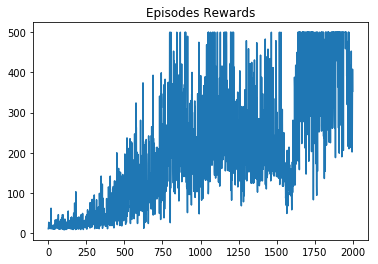

In [5]:
GAMMA           = 0.99
LR              = 0.001
MAX_EPISODES    = 2000
BASELINE_REWARD = 'mean'
EPSILON         = 0.6

agent = PolicyAgent(state_space_size, action_space_size, 100).double()
optimizer = torch.optim.Adam(agent.parameters(), lr=LR)
episode_rewards = []

agent.train()

for episode_no in range(MAX_EPISODES):
    rewards = []
    action_probs = []
    actions = []
    
    done = False
    current_state = env.reset()
    
    # go through an episode
    while not done:
        # get action
        action_dist = agent.get_action(current_state)
        action = action_dist.sample()
        
        next_state, reward, done, _ = env.step(action.item())
        
        # save
        rewards.append(reward)
        actions.append(action)
        action_probs.append(action_dist)
        
        # go next
        current_state = next_state
    
    # update network after an episode -> monte carlo
    returns = calc_discounted_rewards(rewards, GAMMA)
    
    # calculate loss value
    loss = 0
    
    for i in range(len(rewards)):
        loss += action_probs[i].log_prob(actions[i]) * returns[i]
    
    if BASELINE_REWARD == 'mean':
        loss = (loss - np.mean(returns)) / len(rewards)
    else:
        loss = (loss - BASELINE_REWARD) / len(rewards)
    
    # update network params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # print 
    episode_rewards.append(np.sum(rewards))
    
    if episode_no % 50 == 0:
        print('[%d/%d] Mean Reward = %0.2f   Max Reward = %d\t\t\t' %(episode_no, MAX_EPISODES, np.mean(episode_rewards[-50:]), np.max(episode_rewards[-50:])), end='\r', flush=True)
        
# plot each episode's total reward
plt.plot(episode_rewards)
plt.title('Episodes Rewards')
plt.show()

## Test the agent

In [6]:
agent.eval()
done = False
current_state = env.reset()
rewards = []

# go through an episode
while not done:
    # render env
    env.render()
    
    # get BEST action based on the log probabilities -> argmax on them
    action_dist = agent.get_action(current_state)
    log_probs = []
    
    for i in range(action_space_size):
        log_probs.append(action_dist.log_prob(torch.tensor(i)).item())
        
    # perform action
    next_state, reward, done, _ = env.step(np.argmax(log_probs))

    rewards.append(reward)
    
    current_state = next_state
    
env.close()

print('Total Reward = %d' %(np.sum(rewards)))

Total Reward = 402


In [7]:
# benchmark!
agent.eval()
episode_rewards = []

for i in range(100):
    done = False
    current_state = env.reset()
    rewards = []

    # go through an episode
    while not done:
        # get BEST action based on the log probabilities -> argmax on them
        action_dist = agent.get_action(current_state)
        log_probs = []

        for i in range(action_space_size):
            log_probs.append(action_dist.log_prob(torch.tensor(i)).item())

        # perform action
        next_state, reward, done, _ = env.step(np.argmax(log_probs))

        rewards.append(reward)

        current_state = next_state

    episode_rewards.append(np.sum(rewards))
    
print('Min = %d   Max = %d   Mean = %0.2f' %(np.min(episode_rewards), np.max(episode_rewards), np.mean(episode_rewards)))

if np.min(episode_rewards) > 198:
    print('Solved :)')

Min = 314   Max = 500   Mean = 420.40
Solved :)
